In [298]:
from ast import literal_eval as make_tuple
from difflib import SequenceMatcher
import networkx as nx
import pickle5 as pickle
import math
import itertools
from itertools import combinations
from copy import deepcopy
import matplotlib.pyplot as plt
import glob
from copy import deepcopy
import random

random.seed(0)

def read_lc(filename_lc, filename_base_graph, filename_updated_path_graph, filename_deadhead_path_graph, filename_depot, filename_vertexpos):
    ctr = 0
    lcon = {}
    
    f = open(filename_lc, "r")
    for line in f:
        l = [el for el in line.split(';')]
        if ctr != 0:
            lcon[l[0]] = [int(l[1]), int(l[2]), float(l[3]), float(l[4]), int(l[5]), make_tuple(l[6]), float(l[7])]
        ctr+=1

    with open(filename_vertexpos, 'rb') as handle:
        vertexpos = pickle.load(handle)

    with open(filename_depot, 'rb') as handle:
        depot_node = pickle.load(handle)

    T = nx.read_gpickle(filename_base_graph)

    P = nx.read_gpickle(filename_updated_path_graph)

    P_dh = nx.read_gpickle(filename_deadhead_path_graph)

#     plt.figure(figsize=(5,5))
#     nx.draw(P, vertexpos, node_size=5, font_size=8, alpha=0.3, width=0.5)
    
    return lcon, vertexpos, depot_node, T, P, P_dh

In [270]:
def create_stop_dists(lcon, T, P_dh, depot_node):
    end_dh = []
    stops = []
    starts = []
#     for start in lcon.values():
#         if start[0] in P_dh.nodes():
#             stops.append(start[0])
#             end_dh.append(nx.shortest_path(P_dh, depot_node[0], start[0]))
#         else:
#             starts.append(start[0])
    
#     for line in lcon.items():
#         print(line)
#     print(j)
#     print(starts)
#     print(stops)
    added = []
    for t in lcon.values():
#                 print(added)
        start,stop=t[0],t[1]
        pair=(start,stop)
        if stop in P_dh.nodes() and pair not in added and pair[::-1] not in added:           
            starts.append(stop)
            stops.append(start)
            added.append(pair)
            end_dh.append(nx.shortest_path(P_dh, depot_node[0], stop))
        elif start in P_dh.nodes() and pair not in added and pair[::-1] not in added:
            starts.append(start)
            stops.append(stop)
            added.append(pair)
            end_dh.append(nx.shortest_path(P_dh, depot_node[0], start))

#     print(stops)
#     print(starts)
    
#     for st in end_dh:
#         print(st)
#     print('-'*100)
    
    act_path = []
    for i in range(len(stops)):
        act_path.append(nx.shortest_path(T, stops[i], starts[i]))
    
#     for st in act_path:
#         print(st)
#     print('-'*100)
        
    start_dh = []
    for i in range(len(act_path)):
        start_dh.append(create_dh_starts(act_path[i], end_dh[i]))
        
    return start_dh, end_dh

def create_dh_starts(act_path, end_dh):
#     c = deepcopy(act_path)
#     d = deepcopy(end_dh)
#     a = c[::-1]
#     b = d[::-1]
    
#     temp = []
#     check = 0
#     marker = 0

#     for i in range(len(a)):
#         for j in range(len(b)):
#             if a[i] != b[j]:
#                 if a[i] not in temp:
#                     temp.append(a[i])
#             else:
#                 marker = a[i]
#                 check= 1
#                 break

#         if check == 1:
#             break
    
#     print(temp)
    
#     id = b.index(marker)
#     if id == 0:
#         id = -1

#     temp2 = []
#     for i in range(id+1, len(b)):
#         temp2.append(b[i])
#     temp += temp2
# #     print(temp)

    b = act_path
    a = end_dh
    
    if a[0] != b[0] and a[-1] != b[-1]:
        b = b[::-1]
    
#     print(a)
#     print(b)

    s = SequenceMatcher(None, a, b)
    alo, blo, size = s.find_longest_match(0, len(a), 0, len(b))
    c = a[alo:alo+size]
#     print(c)

#     print(b[:blo] + a[:alo+1][::-1])
#     print('%'*100)
    return b[:blo] + a[:alo+1][::-1]
#     return temp


In [11]:
def station_dist(line_pool, T, P_dh, scale, start_dh, depot):
    
    dists = {}
    stations = []
    
    for line in line_pool.values():
        if line[0] not in stations:
            stations.append([line[0], line[5]])
    
    for s1, s2 in combinations(stations, 2):
        if s1[0] not in dists.keys():
            path = nx.shortest_path(T, s1[0], s2[0])
            path_length = 0
            for i in range(1,len(path)):
                dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
                path_length += dist

            dists[s1[0]] = [(s2[0], path_length/scale)]

        else:
            path = nx.shortest_path(T, s1[0], s2[0])
            path_length = 0
            for i in range(1,len(path)):
                dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
                path_length += dist
                    
            if (s2[0], path_length/scale) not in dists[s1[0]]:
                dists[s1[0]].append((s2[0], path_length/scale))
        
        if s2[0] not in dists.keys():
            path = nx.shortest_path(T, s1[0], s2[0])
            path_length = 0
            for i in range(1,len(path)):
                dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
                path_length += dist
                    
            dists[s2[0]] = [(s1[0], path_length/scale)]
            
        else:
            path = nx.shortest_path(T, s1[0], s2[0])
            path_length = 0
            for i in range(1,len(path)):
                dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
                path_length += dist
            
            if (s1[0], path_length/scale) not in dists[s2[0]]:
                dists[s2[0]].append((s1[0], path_length/scale))
    
    for node in dists.keys():
        if (node, 0.0) not in dists[node]:
            dists[node].append((node, 0.0))
    
    dists[depot_node[0]] = []
    
    for path in start_dh:
        path_length = 0
        for i in range(1,len(path)):
            dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
            path_length += dist
        
        dists[depot_node[0]].append((path[0], path_length/scale))
        dists[path[0]].append((depot_node[0], path_length/scale))
    
    for st in stations:
        if st[0] in P_dh.nodes():
            path = nx.shortest_path(P_dh, st[0], depot_node[0])
            path_length = 0
            for i in range(1,len(path)):
                dist = math.sqrt((vertexpos[path[i]][0] - vertexpos[path[i-1]][0]) ** 2.0 + (vertexpos[path[i]][1] - vertexpos[path[i-1]][1]) ** 2.0)
                path_length += dist
            if (depot_node[0], path_length/scale) not in dists[st[0]]:
                dists[st[0]].append((depot_node[0], path_length/scale))
            if (st[0], path_length/scale) not in dists[depot_node[0]]:
                dists[depot_node[0]].append((st[0], path_length/scale))
    
    return dists

# st_dist = station_dist(lcon, P, P_dh, scale, start_dh)
# for st in st_dist.items():
#     print(st[0])
#     print('*'*20)
#     for d in st[1]:
#         print(d)
#     print('-'*20)

In [39]:
# import glob
# x = glob.glob('small/*/')
# print(x)

# for i in x:
#     filename = i+'in/lc.txt'
#     ctr = 0
#     lcon = {}
#     f = open(filename, "r")
#     for line in f:
#         l = [el for el in line.split(';')]
#         if ctr != 0:
#             lcon[l[0]] = [int(l[1]), int(l[2]), float(l[3]), float(l[4]), int(l[5]), make_tuple(l[6]), float(l[7])]
#         ctr+=1
#     for line in lcon.values():
#         print(line)
#     print('-'*100)

# filename_lc = "small/1_cen_3_max_freq_2/out/lc.txt"
# filename_base_graph = "small/1_cen_3_max_freq_2/base_graph.gpickle"
# filename_updated_path_graph = "small/1_cen_3_max_freq_2/out/updated_path_graph.gpickle"
# filename_deadhead_path_graph = "small/1_cen_3_max_freq_2/out/deadhead_path_graph.gpickle"
# filename_depot = "small/1_cen_3_max_freq_2/out/depot_node.pickle"
# filename_vertexpos = "small/1_cen_3_max_freq_2/vertexpos.pickle"

# ctr = 0
# lcon = {}

# f = open(filename_lc, "r")
# for line in f:
#     l = [el for el in line.split(';')]
#     if ctr != 0:
#         lcon[l[0]] = [int(l[1]), int(l[2]), float(l[3]), float(l[4]), int(l[5]), make_tuple(l[6]), float(l[7])]
# #     if ctr > 2:
# #         break
#     ctr+=1

# for line in lcon.items():
#     print(line)

# with open(filename_vertexpos, 'rb') as handle:
#     vertexpos = pickle.load(handle)
    
# with open('small/1_cen_3_max_freq_2/out/depot_node.pickle', 'rb') as handle:
#     depot_node = pickle.load(handle)

# # with open('small/13_cen_3_max_freq_2/base_graph.gpickle', 'rb') as handle:
# #     T = pickle5.load(handle)
    
# T = nx.read_gpickle("small/1_cen_3_max_freq_2/base_graph.gpickle")

# P = nx.read_gpickle("small/1_cen_3_max_freq_2/out/updated_path_graph.gpickle")

# P_dh = nx.read_gpickle("small/1_cen_3_max_freq_2/out/deadhead_path_graph.gpickle")

# print(depot_node)

# plt.figure(figsize=(5,5))
# nx.draw(P, vertexpos, node_size=5, font_size=8, alpha=0.3, width=0.5)

In [15]:
# filename_lc = "small/1_cen_3_max_freq_2/out/lc.txt"
# filename_base_graph = "small/1_cen_3_max_freq_2/base_graph.gpickle"
# filename_updated_path_graph = "small/1_cen_3_max_freq_2/out/updated_path_graph.gpickle"
# filename_deadhead_path_graph = "small/1_cen_3_max_freq_2/out/deadhead_path_graph.gpickle"
filename_depot = "small/1_cen_3_max_freq_2/out/depot_node.pickle"
# filename_vertexpos = "small/1_cen_3_max_freq_2/vertexpos.pickle"

# scale = 20

# print(depot_node)

small\10_cen_2_max_freq_2\in\
[8329, (135.91313541846853, 61.91196118229122)]


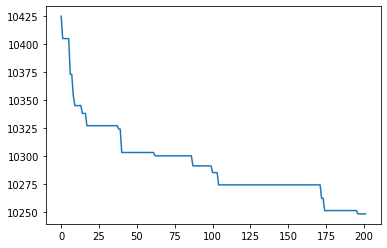

In [70]:
# import glob

# v=['in','out']
# cs=['small','medium']
# for i in v:
#     for s in cs:
#         for j in glob.glob(s+"/*/"+i+'/'):
# #     break
#             filename_lc = j+"lc.txt"
#             filename_base_graph = j.replace(i,'').replace("\\\\","\\")+"base_graph.gpickle"
#             filename_updated_path_graph = j+"updated_path_graph.gpickle"
#             filename_deadhead_path_graph = j+"deadhead_path_graph.gpickle"
#             filename_depot = j+"depot_node.pickle"
#             filename_vertexpos = j.replace(i,'').replace("\\\\","\\")+"vertexpos.pickle"
            
#             scale = 20
            
#             lcon, vertexpos, depot_node, T, P, P_dh = read_lc(filename_lc, filename_base_graph, filename_updated_path_graph, filename_deadhead_path_graph, filename_depot,filename_vertexpos)
            
#             start_dh, end_dh = create_stop_dists(lcon, T, P_dh, depot_node)

#             stop_dist = station_dist(lcon, P, P_dh, scale, start_dh, depot_node)
# #             for i in fls:
# #                 print(i)
            
# #             with open(filename_depot, 'rb') as handle:
# #                 depot_node = pickle.load(handle)
# #             print(j)
# #             print(depot_node)#.replace(i,'').replace("\\\\","\\"))
#             Optimize_SA(lcon, depot_node, stop_dist, j)
            
#             break
# #     print('a')
#     break
    
        
    
    


In [289]:
def Optimize_SA(lcon, depot_node, stop_dist, j):
    speed = 35
    temp = deepcopy(lcon)
    
#     print(j)
    
    b_range = 60 #120 #4

    op_start = 8
    op_end = 22

    trips = create_trips(op_start, op_end, temp)
    trip_copy = deepcopy(trips)
    rem_trips = len(trips)

    buses = {}
    ctr = 0

    deadhead_trips = []

    for i in range(rem_trips):
        buses[i+1] = []

    while ctr < rem_trips:
        if buses[1] == []:
            buses[ctr+1] = [trips[0]]
            first_stop = temp[trips[0][0]][0]

            for st in stop_dist[first_stop]:
                if st[0] == depot_node[0]:
                    first_dh = st[1]
                    
            buses[ctr+1][-1][-1] = round(b_range - trips[0][-1] - first_dh)
            trips.pop(0)
            ctr += 1
        else:
            buses, ctr, dh_trips = new_stop(temp, trips, buses, ctr)
            deadhead_trips.extend(dh_trips)

    bus_schedule = deepcopy(buses)
    dht = deepcopy(deadhead_trips)

    bus_sch = deepcopy(bus_schedule)
    dht = deepcopy(deadhead_trips)

    dht_adj = adjusted_dh(bus_sch, dht)

    # full_sch_vis(bus_sch, dht, j + 'Initial_schedule.png')
    scored_sch = full_sch_scoring(bus_sch, dht_adj)
    # print(stats(scored_sch))

    best, best_score_sch, ndh, score_plot = best_sol_SA(bus_sch, scored_sch, dht, 250, 10000)

    '''
    '''

    sc = []
    it = list(range(len(score_plot)))
    for score in score_plot:
        sc.append(score[1])
    
    plt.figure()
    plt.plot(it, sc)
    plt.show()
    plt.savefig(j+'Score.png')
    # full_sch_vis(best, ndh, j + 'Opt_schedule.png')
    
    return (it, sc)

In [238]:
def create_trips(start, end, line_pool):
    num_trips = 0
    trips = []
    latest = 0
    for line in line_pool.keys():
        num_trips_line = 0
        if start <= line_pool[line][2]:
            earliest = line_pool[line][2]
        else:
            earliest = line_pool[line][2] + math.ceil((start - line_pool[line][2]) * line_pool[line][4])/line_pool[line][4]
        latest = round(earliest + 1/line_pool[line][4],2)
        while latest <= end:
            num_trips += 1
            trips.append([line, round(earliest,2), round(earliest + line_pool[line][3],2), line_pool[line][6]])
            earliest = latest
#             latest = earliest + line_pool[line][3]
            latest = round(earliest + 1/line_pool[line][4],2)
    return sorted(trips, key=lambda y: y[1])

def possible_swap(end_st, stop_dist):
    next_st = stop_dist[end_st]
    next_st.sort(key = lambda tup: tup[1])
    return next_st


def new_stop(line_pool, trips, buses, cov):
    deadhead = []
#     print(depot_node[0])
    lines = deepcopy(line_pool)
    rem_trips = []
    for bus in buses.keys():
        if trips == []:
            for i in range(len(buses)):
                if buses[i+1] == []:
                    del buses[i+1]
            return (buses, cov, deadhead)
            break
            
        if buses[bus] == []:
            buses[bus] = [trips[0]]
            
            for st in stop_dist[first_stop]:
                if st[0] == depot_node[0]:
                    first_dh = st[1]
            
            buses[bus][-1][-1] = round(b_range - trips[0][-1] - first_dh)
            curr_stop = lines[trips[0][0]][1]
            trips.pop(0)
            cov += 1

        curr_time_new = 0
        
        charge_check = 0
        
        new_trav = 0
        
        t = 0
        trip_num = len(trips)
        while t < trip_num:
            if charge_check == 0:
                trav = buses[bus][-1][-1]
                curr_time = buses[bus][-1][2]
            else:
                curr_time = curr_time_new
                trav = new_trav
                charge_check = 0
            
            curr_stop = lines[buses[bus][-1][0]][1]
            nxt_stop = lines[buses[bus][-1][0]][0]
            next_stop_dist = lines[buses[bus][-1][0]][-1]
            dists = possible_swap(curr_stop, stop_dist)
            
            for line in lines.values():
                if line[0] == curr_stop:
                    next_dists = possible_swap(nxt_stop, stop_dist)

            for d in dists:
                if d[0] == depot_node[0]:
                    charge_trip_curr = d[1]
            
            for d in next_dists:
#                 print(nxt_stop)
                if d[0] == depot_node[0]:
                    charge_trip_next = d[1]
#                 print('/'*100)
            
            for st in dists:
                if st[1]/speed <= trips[t][1] - curr_time:
                    if curr_stop == lines[trips[t][0]][0]:
                        nxt_stop_dist = trips[t][-1]
                        proj_trip = next_stop_dist + charge_trip_next
                        if trav - charge_trip_curr > 0: #REDUNDANT
                            if trav - proj_trip > 0:
                                rem_trips.append(trips[t])
                                trips[t][-1] = round(trav-trips[t][-1],2)
                                buses[bus].append(trips[t])
                                cov += 1
                                curr_time_new = trips[t][-2]
                                break
                            else:
                                charge_check = 1
#                                 if bus == 2:
#                                     print(curr_stop, depot_node[0], curr_time, charge_trip_curr)
                                trip_to_depot = [bus, curr_stop, depot_node[0], curr_time, round(curr_time + (charge_trip_curr/speed),2), round(trav - charge_trip_curr,2)]
                                if trip_to_depot not in deadhead:
                                    deadhead.append(trip_to_depot)
#                                 refuel_time = round((b_range - trav + charge_trip_curr) /batt_cap, 2)
                                refuel_time = round((b_range - trav + charge_trip_curr) /b_range, 2)
                                curr_time_new = round(curr_time + (charge_trip_curr/speed) + refuel_time, 2)
                                new_trav = round(b_range - charge_trip_curr,2)
                                trip_from_depot = [bus, depot_node[0], curr_stop, curr_time_new, round(curr_time_new + (charge_trip_curr/speed),2), new_trav]
                                if trip_from_depot not in deadhead:
                                    deadhead.append(trip_from_depot)
                                curr_time_new += charge_trip_curr/speed
                                t -= 1
                                break
            t += 1

        for trip in rem_trips:
            if trip in trips:
                trips.remove(trip)
    
    return (buses, cov, deadhead)

speed = 35
lines = lcon
temp = deepcopy(lcon)

# for id in lcon.keys():
#     if int(id[1]) > 4 or len(id) > 2:
#         del temp[id]


# print(stop_dist.keys())

b_range = 60 #120 #4

op_start = 8
op_end = 22

# print('Lines in use: ', temp)
# print('-'*100)

# print('Operation time range: ', op_start, '-', op_end)
# print('-'*100)

trips = create_trips(op_start, op_end, temp)
trip_copy = deepcopy(trips)
rem_trips = len(trips)

# print('Number of trips: ', rem_trips)
# print('-'*100)

# print('Trips: ')
# for t in trips:
#     print(t)
# print('-'*100)

buses = {}
ctr = 0

deadhead_trips = []

for i in range(rem_trips):
    buses[i+1] = []

while ctr < rem_trips:
    if buses[1] == []:
        buses[ctr+1] = [trips[0]]
        first_stop = temp[trips[0][0]][0]
        
        for st in stop_dist[first_stop]:
            if st[0] == depot_node[0]:
                first_dh = st[1]
        
        buses[ctr+1][-1][-1] = round(b_range - trips[0][-1] - first_dh)
        trips.pop(0)
        ctr += 1
    else:
        buses, ctr, dh_trips = new_stop(temp, trips, buses, ctr)
        deadhead_trips.extend(dh_trips)

# print('Bus schedule: ')
# for bus in buses.items():
#     print('*'*50)
#     print('Bus ' + str(bus[0]) + ' : ')
#     for t in bus[1]:
#         print(t)
# print('-'*100)

# print('Deadhead trips: ')
# for dh in deadhead_trips:
#     print(dh)

bus_schedule = deepcopy(buses)
dht = deepcopy(deadhead_trips)

small\10_cen_2_max_freq_2\in\


'\n'

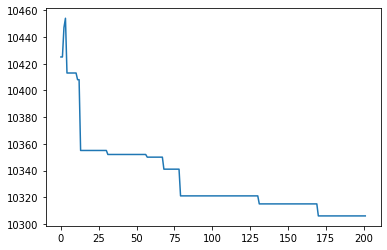

In [74]:
# speed = 35
# temp = deepcopy(lcon)

# b_range = 60 #120 #4

# op_start = 8
# op_end = 22

# trips = create_trips(op_start, op_end, temp)
# trip_copy = deepcopy(trips)
# rem_trips = len(trips)

# buses = {}
# ctr = 0

# deadhead_trips = []

# for i in range(rem_trips):
#     buses[i+1] = []

# while ctr < rem_trips:
#     if buses[1] == []:
#         buses[ctr+1] = [trips[0]]
#         first_stop = temp[trips[0][0]][0]
        
#         for st in stop_dist[first_stop]:
#             if st[0] == depot_node[0]:
#                 first_dh = st[1]
        
#         buses[ctr+1][-1][-1] = round(b_range - trips[0][-1] - first_dh)
#         trips.pop(0)
#         ctr += 1
#     else:
#         buses, ctr, dh_trips = new_stop(temp, trips, buses, ctr)
#         deadhead_trips.extend(dh_trips)

# bus_schedule = deepcopy(buses)
# dht = deepcopy(deadhead_trips)

# '''

# new_schedule = {}
# dh_tripz = adjusted_dh(bus_schedule, deadhead_trips)

# trip_num = 0
# for bus in bus_schedule.keys():
#     new_sch = []
#     for trip in bus_schedule[bus]:
#         new_sch.append([('t', trip[0]), trip[1], trip[2], trip[3]])
#         trip_num += 1
    
#     for dh in dh_tripz:
#             if dh[0] == bus:
#                 new_sch.append([('d', None), dh[3], dh[4], dh[5]])
    
#     new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

# for bus in new_schedule.keys():
#     charging_trips = []
#     for t in range(1,len(new_schedule[bus])):
#         if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
#             if new_schedule[bus][t-1][0][0] == 'd' and new_schedule[bus][t-1][0][0] == new_schedule[bus][t][0][0]:
#                 label = 'c'
#                 trav = b_range
#             else:
#                 label = 's'
#                 trav = new_schedule[bus][t-1][3]
#             charging_trips.append([(label, None), new_schedule[bus][t-1][2], new_schedule[bus][t][1], trav])
#     new_schedule[bus].extend(charging_trips)
#     new_schedule[bus].sort(key=lambda y: y[1])
    
# '''
# '''

# bus_sch = deepcopy(bus_schedule)

# dht = deepcopy(deadhead_trips)

# check_bus_1 = 1
# check_bus_2 = 1
# while check_bus_1 == 1 and check_bus_2 == 1:
#     new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(bus_sch, dht)
#     check_bus_1 = len(new_bus_1)
#     check_bus_2 = len(new_bus_2)

# '''
# '''

# ctr = 0

# nschd = deepcopy(new_schd)
# ndh_t = deepcopy(dht_new)

# if rem_tripzz != []:
#     while ctr < len(rem_tripzz):
#         new_s, new_ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
#         for dh in dh_t:
#             if dh not in ndh_t:
#                 ndh_t.append(dh)
#         if new_ctr == ctr:
#             new_s[len(new_s.keys())+1] = []
#             ctr = new_ctr
# else:
#     new_s = deepcopy(nschd)

# ndh_t_copy = adjusted_dh(new_s, ndh_t)

# '''

# bus_sch = deepcopy(bus_schedule)
# dht = deepcopy(deadhead_trips)

# dht_adj = adjusted_dh(bus_sch, dht)

# # full_sch_vis(bus_sch, dht, j + 'Initial_schedule.png')
# scored_sch = full_sch_scoring(bus_sch, dht_adj)
# # print(stats(scored_sch))

# best, best_score_sch, ndh, score_plot = best_sol_SA(bus_sch, scored_sch, dht, 250, 10000)

# '''
# '''

# sc = []
# it = list(range(len(score_plot)))
# for score in score_plot:
#     sc.append(score[1])

# plt.plot(it, sc)
# print(j)
# plt.savefig(j+'Score.png')

# '''
# '''

# # full_sch_vis(best, ndh, j + 'Opt_schedule.png')

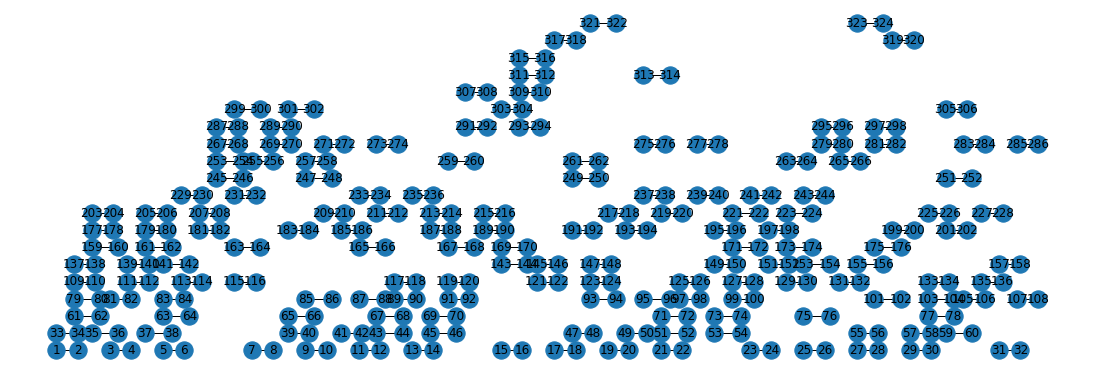

In [55]:
'''
SCHEDULE VISUALISATION
'''

ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in bus_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('schedule_basic.png')

20


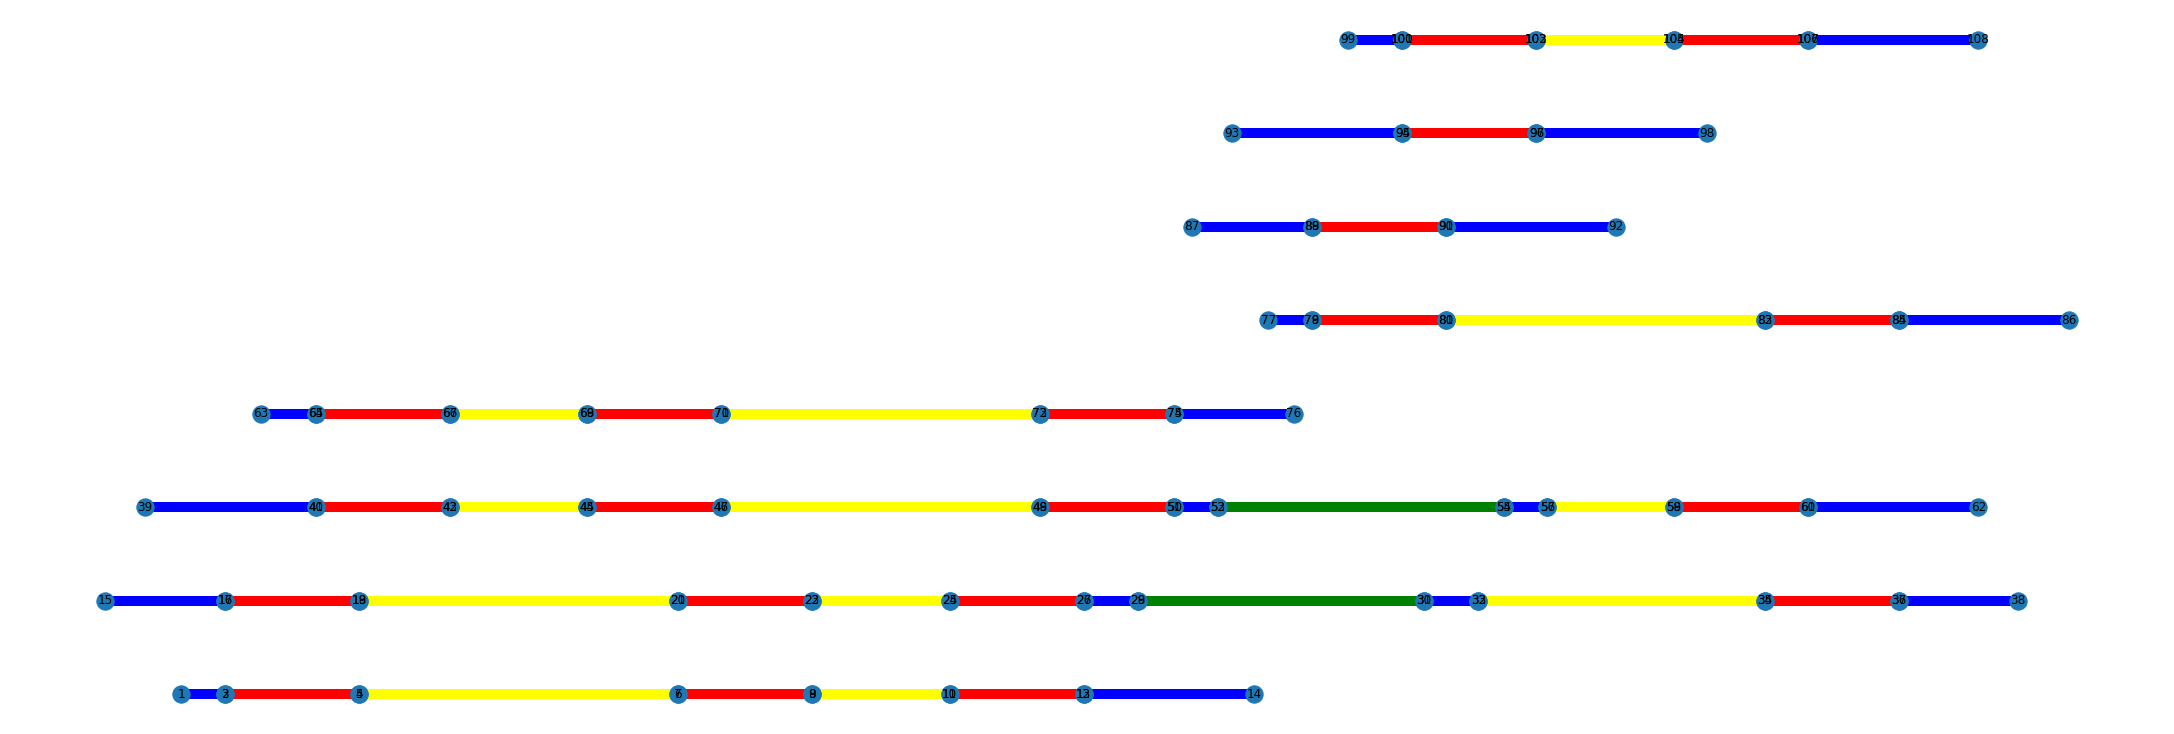

In [27]:
'''
REVISED: COMPLETE SCHEDULE
'''

new_schedule = {}
dh_tripz = adjusted_dh(bus_schedule, deadhead_trips)

trip_num = 0
for bus in bus_schedule.keys():
    new_sch = []
    for trip in bus_schedule[bus]:
        new_sch.append([('t', trip[0]), trip[1], trip[2], trip[3]])
        trip_num += 1
    
    for dh in dh_tripz:
            if dh[0] == bus:
                new_sch.append([('d', None), dh[3], dh[4], dh[5]])
    
    new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

print(trip_num)

for bus in new_schedule.keys():
    charging_trips = []
    for t in range(1,len(new_schedule[bus])):
        if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
            if new_schedule[bus][t-1][0][0] == 'd' and new_schedule[bus][t-1][0][0] == new_schedule[bus][t][0][0]:
                label = 'c'
                trav = b_range
            else:
                label = 's'
                trav = new_schedule[bus][t-1][3]
            charging_trips.append([(label, None), new_schedule[bus][t-1][2], new_schedule[bus][t][1], trav])
#     for trip in charging_trips:
    new_schedule[bus].extend(charging_trips)
    new_schedule[bus].sort(key=lambda y: y[1])


ctr = 1
pos = {}
edges = []
edge_color = []

new_trip_graph = nx.Graph()
for bus in new_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        if seq[0][0] == 't':
            edge_color.append('red')
        elif seq[0][0] == 'd':
            edge_color.append('blue')
        elif seq[0][0] == 'c':
            edge_color.append('green')
        else:
            edge_color.append('yellow')

fig = plt.figure(figsize=(30,10))
new_trip_graph.add_nodes_from(pos)
new_trip_graph.add_edges_from(edges)
nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
plt.savefig('schedule.png')

Trip count  20
2
^^^^^
['l3', 9.25, 9.62, 43]
['l4', 10.5, 10.87, 30.22]
['l3', 11.25, 11.62, 17.44]
['l1', 13.25, 13.62, 42.83]
--------------------------------------------------
3
^^^^^
['l2', 9.5, 9.87, 43]
['l1', 10.25, 10.62, 29.94]
['l2', 11.5, 11.87, 16.88]
['l4', 13.5, 13.87, 42.14]
--------------------------------------------------
Rem trips  0
Dh_trips  8
[1, 8549, 8329, 11.62, 12.09, 0.26]
[1, 8329, 8549, 13.09, 13.56, 43.38]
[4, 8465, 8329, 11.87, 12.2, 5.9]
[4, 8329, 8465, 13.1, 13.43, 48.46]
[2, 8022, 8329, 11.62, 11.77, 12.36]
[2, 8329, 8013, 12.56, 12.68, 55.89]
[3, 8013, 8329, 11.87, 11.99, 12.77]
[3, 8329, 8022, 12.78, 12.93, 54.92]


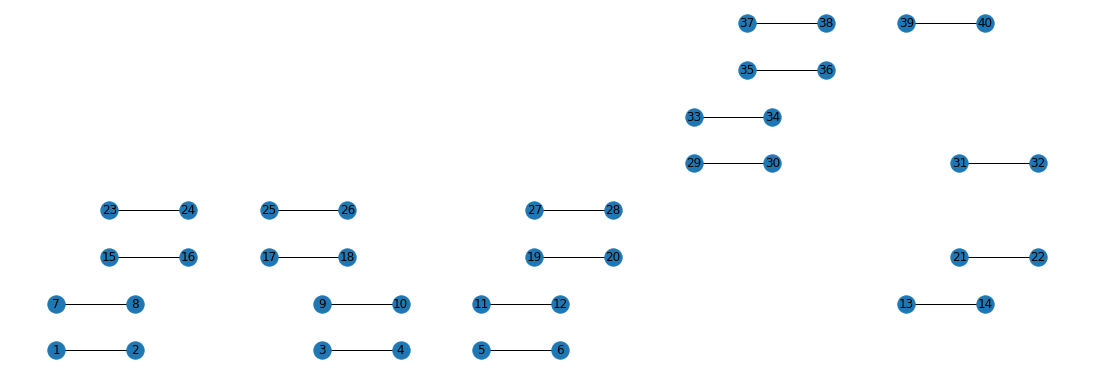

In [20]:
import random
from itertools import combinations

def trip_check(bus_1, bus_2, swap_time):
    trip_copy = create_trips(op_start, op_end, temp)
    
    trip_1 = None
    trip_2 = None
    temp_1 = None
    temp_2 = None
    
    for t in range(len(bus_1)):
        if bus_1[t][1] > swap_time:
            temp_1 =  bus_1[t]
            break

    for t in range(len(bus_2)):
        if bus_2[t][1] > swap_time:
            temp_2 = bus_2[t]
            break
    
    if temp_1 != None:
        for trip in trip_copy:
            if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
#                 print(trip)
                trip_1 = trip
                break

    if temp_2 != None:
        for trip in trip_copy:
            if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
#                 print(trip)
                trip_2 = trip
                break
    
#     print(bus_1)
#     print(bus_2)
#     print('%'*50)
    return (trip_1, trip_2)

def swap_check(bus_schedule, dh_trips):
    check = 0
#     dh_trips_new = deepcopy(dh_trips)
#     bus_sch = deepcopy(bus_schedule)
#     bus_num = list(bus_sch.keys())
    iterat = 0
    while check == 0:
        dh_trips_new = deepcopy(dh_trips)
        bus_sch = deepcopy(bus_schedule)
        bus_num = list(bus_sch.keys())
        random.shuffle(bus_num)
        t = random.uniform(op_start, op_end)
        bus_1 = bus_sch[bus_num[0]]
        bus_2 = bus_sch[bus_num[1]]
        old_bus_1 = deepcopy(bus_1)
        old_bus_2 = deepcopy(bus_2)
        
        trip_1, trip_2 = trip_check(bus_1, bus_2, t)
        
        if trip_1 != None and trip_2 != None:
            temp_1 = None
            temp_2 = None
            rem_trips = []

            for trip in bus_1:
                if trip[1] == trip_1[1] and trip[2] == trip_1[2]:
                    temp_1 = trip
                if trip[1] > trip_1[2]:
                    rem_trips.append(trip)
            
            for trip in bus_2:
                if trip[1] == trip_2[1] and trip[2] == trip_2[2]:
                    temp_2 = trip
                if trip[1] > trip_2[2]:
                    rem_trips.append(trip)
            
#             print(iterat)
#             print(temp_1)
#             print(temp_2)
            
            bus_1.remove(temp_1)
            bus_2.remove(temp_2)
            for el in rem_trips:
                if el in bus_1:
                    bus_1.remove(el)
                if el in bus_2:
                    bus_2.remove(el)
            
            bus_1.append(trip_2)
            bus_2.append(trip_1)

#             print(bus_num[0], bus_1)
#             print(bus_num[1], bus_2)
#             print('-'*100)
            

            for dh in dh_trips:
                if dh[0] == bus_num[0]:
#                     print(dh, len(bus_1), 'a')
                    if len(bus_1) > 1:
                        if dh[-3] > bus_1[-2][1]:
                            dh_trips_new.remove(dh)
                    else:
                        dh_trips_new.remove(dh)
                elif dh[0] == bus_num[1]:
#                     print(dh, len(bus_2), 'b')
                    if len(bus_2) > 1:
                        if dh[-3] > bus_2[-2][1]:
                            dh_trips_new.remove(dh)
                    else:
                        dh_trips_new.remove(dh)
            
            # delete deadheads for buses 1,2 after swap
            # in particular, delete deadheads if their end time exceeds swapped trip's start time
            
            nsf1 = new_sch_feas_test(bus_1, bus_num[0])
            nsf2 = new_sch_feas_test(bus_2, bus_num[1])
            
            if nsf1[0] == 0 or nsf2[0] == 0:
                continue
            else:
                if bus_1 != old_bus_2 and bus_2 != old_bus_1:
                    bus_1_dh = nsf1[1]
                    bus_2_dh = nsf2[1]

                    if bus_1_dh is None and bus_2_dh is None:
                        
#                         print('c', len(dh_trips_new))
                        for trip in rem_trips:
                            for orig_trip in trip_copy:
                                if trip[0] == orig_trip[0] and trip[1] == orig_trip[1] and trip[2] == orig_trip[2]:
                                    trip[-1] = orig_trip[-1]
                        
                        return (bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new)
                    
                    else:
#                         print('a', len(dh_trips_new))
                        
                        dh_to_rem = []
                        
                        if bus_1_dh is not None:
                            
                            timer = bus_1_dh[0][-3]
                            
                            for old_dht in dh_trips_new:
                                if old_dht[0] == bus_num[0]:
                                    if old_dht[-3] >= timer:
                                        dh_to_rem.append(old_dht)
                            
                            for dh in dh_to_rem:
                                dh_trips_new.remove(dh)

                            dh_trips_new.extend(bus_1_dh)

                        
                        dh_to_rem = []
                        if bus_2_dh is not None:
                            
                            timer = bus_2_dh[0][-3]
                            
                            for old_dht in dh_trips_new:
                                if old_dht[0] == bus_num[1]:
                                    if old_dht[-3] >= timer:
                                        dh_to_rem.append(old_dht)
                            
                            for dh in dh_to_rem:
                                dh_trips_new.remove(dh)

                            dh_trips_new.extend(bus_2_dh)
                        
#                         print(len(dh_trips_new))
                        
                        for trip in rem_trips:
                            for orig_trip in trip_copy:
                                if trip[0] == orig_trip[0] and trip[1] == orig_trip[1] and trip[2] == orig_trip[2]:
                                    trip[-1] = orig_trip[-1]
                                    
                        return (bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new)

        else:
            t = random.uniform(op_start, op_end)
            iterat += 1

def new_sch_feas_test(bus, bus_id):  
    buffer = 0.03
    if len(bus) > 1:
        if bus[-1][0] == bus[-2][0]:
#             print('a')
            return [0, None]
            # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
        else:
            # FIGURE OUT LAST TRIP; DEADHEAD OR SERVICE
            start_stop = lines[bus[-1][0]][0]
            end_stop = lines[bus[-1][0]][1]
            
            prev_stop = lines[bus[-2][0]][1]
            prev_trip_end = bus[-2][2]
            prev_trip_start = bus[-2][1]
            rem_fuel = bus[-2][-1]

            prev_stop_dists = possible_swap(prev_stop, stop_dist)
            for d in prev_stop_dists:
                if d[0] == depot_node[0]:
                    charge_trip_next = d[1]
            
            curr_trip_start = bus[-1][1]

            for st in stop_dist[prev_stop]:

                if start_stop == st[0]:
                    
                    if prev_trip_end + buffer + st[1]/speed > curr_trip_start:
                        return [0, None]
                        # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
                    else:
                        start_stop_dists = possible_swap(start_stop, stop_dist)
                        for d in start_stop_dists:
                            if d[0] == depot_node[0]:
                                charge_trip_to = d[1]
                        
                        end_stop_dists = possible_swap(end_stop, stop_dist)
                        for d in end_stop_dists:
                            if d[0] == depot_node[0]:
                                charge_trip_end = d[1]
                        
                        refuel_time = round((b_range - rem_fuel + charge_trip_next)/b_range , 2)
                        
                        if rem_fuel - st[1] - bus[-1][-1] - charge_trip_end <= 0:

                            if prev_trip_end + buffer + refuel_time + (charge_trip_next + charge_trip_to)/speed > curr_trip_start:
                                
                                return [0, None]
                                
                                # NOT ENOUGH FUEL FOR THE LAST TRIP AND NO TIME IN BETWEEN TO CHARGE
                            
                            else:
                                charging_start_time = round(prev_trip_end + charge_trip_next/speed, 2)
                                trip_to_depot = [bus_id, prev_stop, depot_node[0], prev_trip_end, charging_start_time, round(rem_fuel - charge_trip_next,2)]
                                trip_from_depot = [bus_id, depot_node[0], start_stop, round(charging_start_time + refuel_time, 2), round(charging_start_time + refuel_time + (charge_trip_to/speed),2), round(b_range - charge_trip_to, 2)]
                                new_dh = [trip_to_depot, trip_from_depot]
                                bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)
                                return [1, new_dh]
                            
                                # CHARGING POSSIBLE IN BETWEEN

                        else: 
                            if prev_stop != start_stop:
#                                 print(bus_id, charge_trip_end)
                                new_dh = [[bus_id, prev_stop, start_stop, prev_trip_end, round(prev_trip_end + (st[1]/speed),2), round(rem_fuel - st[1],2)]]
                                bus[-1][-1] = round(rem_fuel - st[1] - bus[-1][-1], 2)
                                return [1, new_dh]
                            else:
#                                 print(bus_id, charge_trip_end)
                                bus[-1][-1] = round(rem_fuel - bus[-1][-1], 2)
                                return [1, None]
                            
    else:
        bus_st = lcon[bus[-1][0]][0]
        for d in stop_dist[bus_st]:
            if d[0] == depot_node[0]:
                depot_dist = d[1]
        bus[-1][-1] = round(b_range - depot_dist - bus[-1][-1], 2)
        return [1, None]
        # SWAPPED TRIP IS THE FIRST POSSIBLE

bus_sch = deepcopy(bus_schedule)

dht = deepcopy(deadhead_trips)
# for dh in dht:
#     print(dh)
# print('-'*50)

check_bus_1 = 1
check_bus_2 = 1
while check_bus_1 == 1 and check_bus_2 == 1:
    new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(bus_sch, dht)
#     new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(new_new_s, new_new_dht)
    check_bus_1 = len(new_bus_1)
    check_bus_2 = len(new_bus_2)


temp_sch = {}
trip_ct = 0

for bus in new_schd.values():
    trip_ct += len(bus)

print('Trip count ', trip_ct)

for bus in bus_sch.items():
    if old_bus_1 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]
    elif old_bus_2 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]

# for bus in new_new_s.items():
#     if old_bus_1 == bus[1]:
#         temp_sch[bus[0]] = new_schd[bus[0]]
#     elif old_bus_2 == bus[1]:
#         temp_sch[bus[0]] = new_schd[bus[0]]

# print(old_bus_1)
# print('-'*50)
        
for bus in temp_sch.items():
    print(bus[0])
    print('^'*5)
    for t in bus[1]:
        print(t)
    print('-'*50)

print('Rem trips ', len(rem_trips))
for t in rem_trips:
    print(t)

# print(len(dht_new))
# print('-'*50)

print('Dh_trips ', len(dht_new))
for dh in dht_new:
#     if dh is not None:
#         if dh[0] in temp_sch.keys():
    print(dh)

ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_schd.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))      
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basic.png')

--------------------------------------------------
(1, [['l1', 9.25, 9.62, 43], ['l2', 10.5, 10.87, 29.94], ['l1', 11.25, 11.62, 16.88]])
(2, [['l3', 9.25, 9.62, 43], ['l4', 10.5, 10.87, 30.22], ['l3', 11.25, 11.62, 17.44], ['l1', 13.25, 13.62, 42.83]])
(3, [['l2', 9.5, 9.87, 43], ['l1', 10.25, 10.62, 29.94], ['l2', 11.5, 11.87, 16.88], ['l4', 13.5, 13.87, 42.14]])
(4, [['l4', 9.5, 9.87, 43], ['l3', 10.25, 10.62, 30.22], ['l4', 11.5, 11.87, 17.44]])
(5, [['l1', 12.25, 12.62, 43], ['l2', 13.5, 13.87, 29.94]])
(6, [['l3', 12.25, 12.62, 43]])
(7, [['l2', 12.5, 12.87, 43]])
(8, [['l4', 12.5, 12.87, 43], ['l3', 13.25, 13.62, 30.22]])
--------------------------------------------------
[1, 8549, 8329, 11.62, 12.09, 0.26]
[1, 8329, 8549, 13.09, 13.56, 43.38]
[4, 8465, 8329, 11.87, 12.2, 5.9]
[4, 8329, 8465, 13.1, 13.43, 48.46]
[2, 8022, 8329, 11.62, 11.77, 12.36]
[2, 8329, 8013, 12.56, 12.68, 55.89]
[3, 8013, 8329, 11.87, 11.99, 12.77]
[3, 8329, 8022, 12.78, 12.93, 54.92]


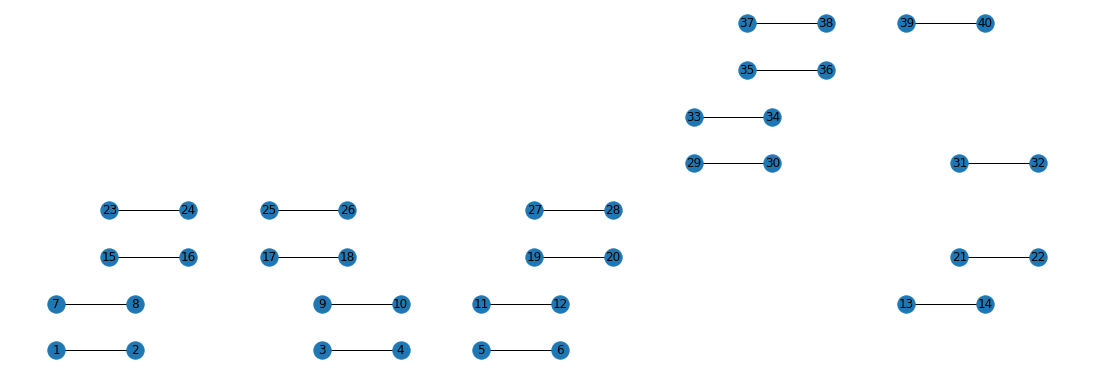

In [31]:
def new_stops(line_pool, trips, buses, deadhead, cov):
    lines = deepcopy(line_pool)
    rem_trips = []
    for bus in buses.keys():
        if trips == []:
            for i in range(len(buses)):
                if buses[i+1] == []:
                    del buses[i+1]
            return (buses, cov, deadhead)
            break
        
        if buses[bus] == []:
            buses[bus] = [trips[0]]
            for st in stop_dist[first_stop]:
                if st[0] == depot_node[0]:
                    first_dh = st[1]
            buses[bus][-1][-1] = round(b_range - trips[0][-1] - first_dh)
            curr_stop = lines[trips[0][0]][1]
            trips.pop(0)
            cov += 1
            
        curr_time_new = 0
        
        charge_check = 0
        
        new_trav = 0
        
        t = 0
        trip_num = len(trips)
        
        while t < trip_num:
            
            if charge_check == 0:
                trav = buses[bus][-1][-1]
                curr_time = buses[bus][-1][2]
            else:
                curr_time = round(curr_time_new, 2)
                trav = new_trav
                charge_check = 0
       
            
            curr_stop = lines[buses[bus][-1][0]][1]
#             nxt_stop = lines[buses[bus][-1][0]][0]
            nxt_start_stop = lines[trips[t][0]][0]
            nxt_end_stop = lines[trips[t][0]][1]
    
            dists = possible_swap(curr_stop, stop_dist)
            
            next_dists = possible_swap(nxt_end_stop, stop_dist)
            
            for d in dists:
                if d[0] == depot_node[0]:
                    charge_trip_curr = d[1]
            
            for d in next_dists:
                if d[0] == depot_node[0]:
                    charge_trip_next = d[1]


            for st in dists:
                if nxt_start_stop == st[0]:
                    if curr_time + st[1]/speed <= trips[t][1]:
                            
                        proj_trip = st[1] + trips[t][-1] + charge_trip_next

                        if trav - proj_trip > 0:
                            rem_trips.append(trips[t])
                            trips[t][-1] = round(trav - trips[t][-1] - st[1],2)
                            buses[bus].append(trips[t])
                            if curr_stop != nxt_start_stop:
                                dh_tr = [bus, curr_stop, nxt_start_stop, curr_time, round(curr_time + (st[1]/speed),2), round(trav - st[1], 2)]
                                deadhead.append(dh_tr)
                            cov += 1
                            curr_time_new = trips[t][-2]
                            break
                        else:
#                             print('ddd', bus, trips[t], proj_trip)
                            charge_check = 1
                            trip_to_depot = [bus, curr_stop, depot_node[0], curr_time, round(curr_time + (charge_trip_curr/speed),2), round(trav - charge_trip_curr,2)]
                            if trip_to_depot not in deadhead:
                                deadhead.append(trip_to_depot)
#                                 refuel_time = round((b_range - trav + charge_trip_curr) * 0.1, 2)
                            refuel_time = round((b_range - trav + charge_trip_curr)/b_range, 2)
                            curr_time_new = round(curr_time + (charge_trip_curr/speed) + refuel_time, 2)
                            new_trav = round(b_range - charge_trip_curr,2)
                            trip_from_depot = [bus, depot_node[0], curr_stop, curr_time_new, round(curr_time_new + (charge_trip_curr/speed),2), new_trav]
                            if trip_from_depot not in deadhead:
                                deadhead.append(trip_from_depot)
                            curr_time_new += charge_trip_curr/speed
                            t -= 1
                            break
#                         else:
#                             print('bbb')
            t += 1

        for trip in rem_trips:
            if trip in trips:
                trips.remove(trip)
    
    return (buses, cov, deadhead)    

ctr = 0

nschd = deepcopy(new_schd)
ndh_t = deepcopy(dht_new)

# for dh in ndh_t:
#     print(dh)
# print('*'*50)

rem_tripzz = deepcopy(rem_trips)
for trip in rem_tripzz:
    print(trip)#rem_tripzz)
print('-'*50)

if rem_tripzz != []:
    while ctr < len(rem_tripzz):
        new_s, new_ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
        for dh in dh_t:
            if dh not in ndh_t:
                ndh_t.append(dh)
        if new_ctr == ctr:
            new_s[len(new_s.keys())+1] = []
            ctr = new_ctr
#         if new_s == nschd:
#             print(ctr)
#         for dh in dh_t:
#             if dh not in ndh_t:
#                 ndh_t.append(dh_t)
else:
    new_s = deepcopy(nschd)


# print(rem_tripzz)
# print('*'*50)

# for bus in temp_sch.items():
#     print(bus[0])
#     print('^'*5)
#     for t in bus[1]:
#         print(t)
#     print('-'*50)

for bus in new_s.items():
    print(bus)
print('-'*50)

for dh in ndh_t:
#     if dh[0] in temp_sch.keys():
    print(dh)


ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_s.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basiczz.png')

ndh_t_copy = adjusted_dh(new_s, ndh_t)

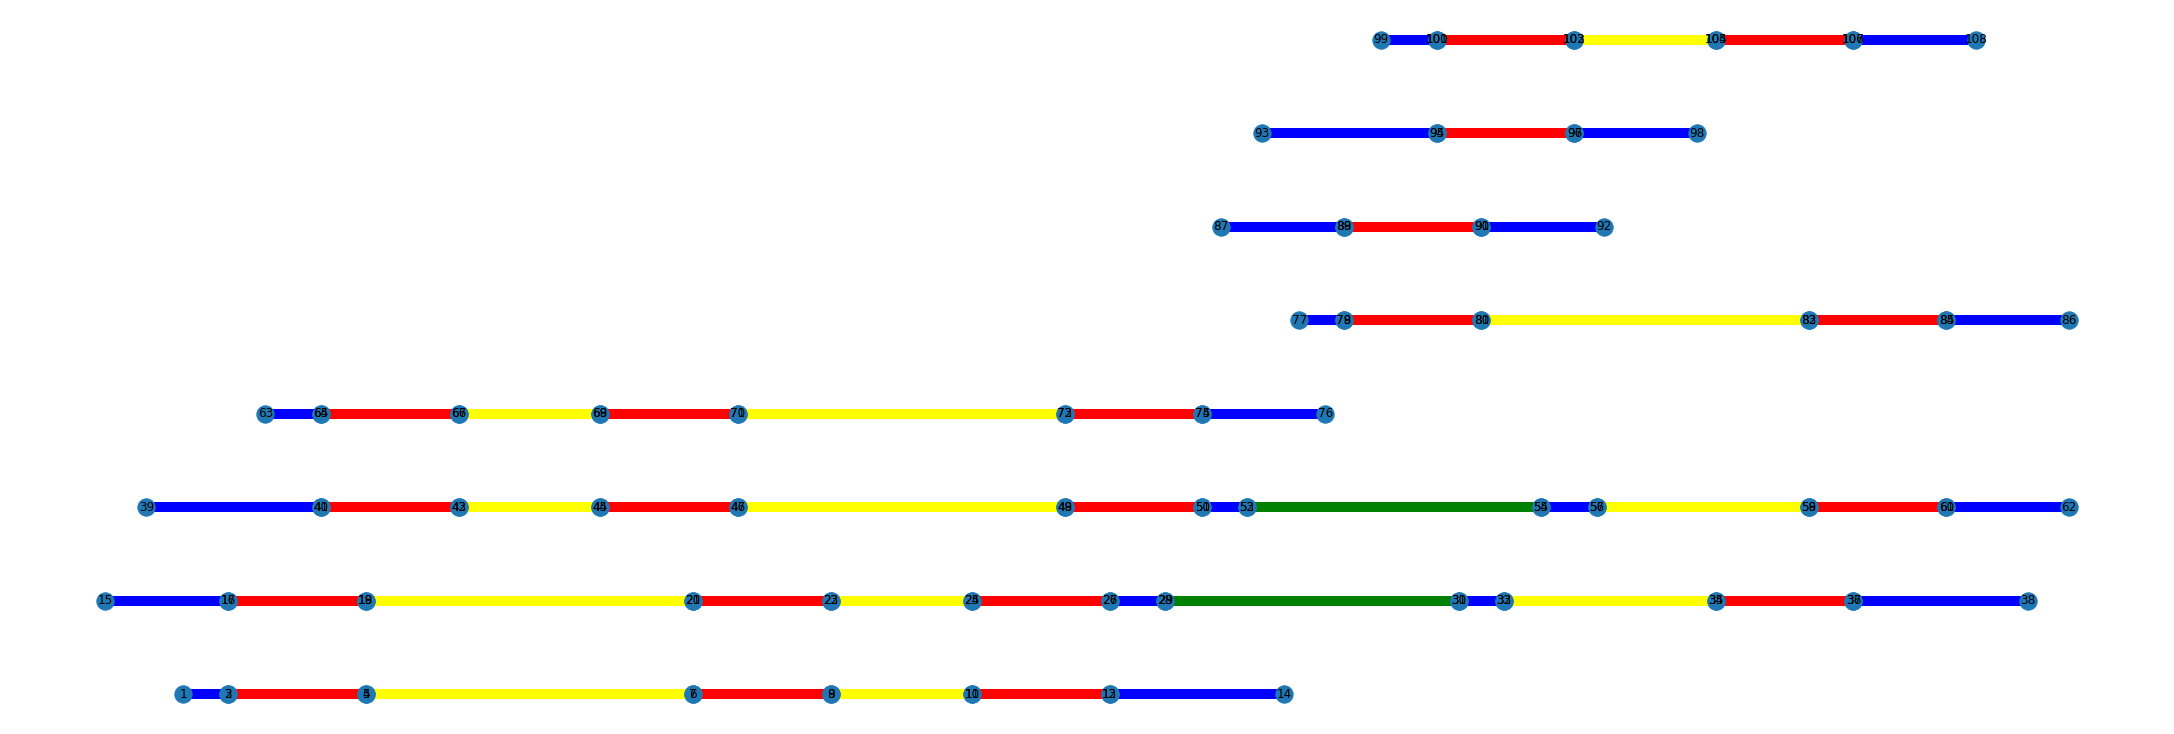

In [33]:
swapped_schedule = {}
dh_tripz = deepcopy(ndh_t_copy)

for bus in new_s.keys():
    new_sch = []
    for trip in new_s[bus]:
        new_sch.append(['t', trip[1], trip[2]])
    
    for dh in dh_tripz:
            if dh[0] == bus:
                new_sch.append(['d', dh[3], dh[4]])
    
    swapped_schedule[bus] = sorted(new_sch, key=lambda y: y[1])   

swapped_schedule_copy = deepcopy(swapped_schedule)

for bus in swapped_schedule.keys():
    charging_trips = []
    for t in range(1,len(swapped_schedule[bus])):
        if swapped_schedule[bus][t][1] != swapped_schedule[bus][t-1][2]:
            if swapped_schedule[bus][t-1][0] == 'd' and swapped_schedule[bus][t-1][0] == swapped_schedule[bus][t][0]:
                label = 'c'
            else:
                label = 's'
            charging_trips.append([label, swapped_schedule[bus][t-1][2], swapped_schedule[bus][t][1]])
        
    swapped_schedule[bus].extend(charging_trips)
    swapped_schedule[bus].sort(key=lambda y: y[1])
    
for bus in swapped_schedule.keys():
    for t in range(2,len(swapped_schedule[bus])):
        if swapped_schedule[bus][t][0] == 'c' and swapped_schedule[bus][t-2][0] == swapped_schedule[bus][t][0]:
            print(swapped_schedule[bus][t])
            swapped_schedule[bus][t][0] = 's'
#     break
    

ctr = 1
pos = {}
edges = []
edge_color = []

new_trip_graph = nx.Graph()
for bus in swapped_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        if seq[0] == 't':
            edge_color.append('red')
        elif seq[0] == 'd':
            edge_color.append('blue')
        elif seq[0] == 'c':
            edge_color.append('green')
        else:
            edge_color.append('yellow')

fig = plt.figure(figsize=(30,10))
new_trip_graph.add_nodes_from(pos)
new_trip_graph.add_edges_from(edges)
nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
plt.savefig('swapped_schedule.png')

In [34]:
def adjusted_dh(new_s, ndh_t):

    ndh_t_copy = deepcopy(ndh_t)
    for bus in new_s.items():
        first_bus_trip = bus[1][0]
        start_st = lcon[first_bus_trip[0]][0]
        for d in stop_dist[start_st]:
            if d[0] == depot_node[0]:
                first_dh = d[1]
        
        last_bus_trip = bus[1][-1]
        end_st = lcon[last_bus_trip[0]][1]
        for d in stop_dist[end_st]:
            if d[0] == depot_node[0]:
                last_dh = d[1]
        
        max_dh = None
        max_dh_time = 0
        for dh in ndh_t_copy:
            if dh[0] == bus[0]:
                if max_dh_time < dh[-2]:
                    max_dh = dh
                    max_dh_time = dh[-2]
        if max_dh is not None:
            if last_bus_trip[-2] < max_dh_time:
                ndh_t_copy.remove(max_dh)
            else:
                ndh_t_copy.append([bus[0], end_st, depot_node[0], last_bus_trip[2], round(last_bus_trip[2] + last_dh/speed, 2), round(last_bus_trip[-1] - last_dh, 2)])
        else:
            ndh_t_copy.append([bus[0], end_st, depot_node[0], last_bus_trip[2], round(last_bus_trip[2] + last_dh/speed, 2), round(last_bus_trip[-1] - last_dh, 2)])

        ndh_t_copy.append([bus[0], depot_node[0], start_st, round(first_bus_trip[1] - first_dh/speed, 2), first_bus_trip[1], round(b_range - first_dh, 2)])
    
    return ndh_t_copy

In [45]:
def full_sch_scoring(new_s, ndh_t):
    swapped_schedule = {}
    # print(deadhead_trips)
    dh_tripz = deepcopy(ndh_t)
    
    trip_num = 0
    for bus in new_s.keys():
        new_sch = []
        for trip in new_s[bus]:
            new_sch.append(['t', trip[1], trip[2]])
            trip_num += 1

        for dh in dh_tripz:
                if dh[0] == bus:
                    new_sch.append(['d', dh[3], dh[4]])

        swapped_schedule[bus] = sorted(new_sch, key=lambda y: y[1])   

    swapped_schedule_copy = deepcopy(swapped_schedule)

    for bus in swapped_schedule.keys():
        charging_trips = []
        for t in range(1,len(swapped_schedule[bus])):
            if swapped_schedule[bus][t][1] != swapped_schedule[bus][t-1][2]:
                if swapped_schedule[bus][t-1][0] == 'd' and swapped_schedule[bus][t-1][0] == swapped_schedule[bus][t][0]:
                    label = 'c'
                else:
                    label = 's'
                charging_trips.append([label, swapped_schedule[bus][t-1][2], swapped_schedule[bus][t][1]])

        swapped_schedule[bus].extend(charging_trips)
        swapped_schedule[bus].sort(key=lambda y: y[1])

    for bus in swapped_schedule.keys():
        for t in range(2,len(swapped_schedule[bus])):
            if swapped_schedule[bus][t][0] == 'c' and swapped_schedule[bus][t-2][0] == swapped_schedule[bus][t][0]:
#                 print(swapped_schedule[bus][t])
                swapped_schedule[bus][t][0] = 's'
    #     break


    ctr = 1
    pos = {}
    edges = []
    edge_color = []

    new_trip_graph = nx.Graph()
    for bus in swapped_schedule.items():
        for seq in bus[1]:
            pos[ctr] = (seq[1], bus[0])
            ctr += 1
            pos[ctr] = (seq[2], bus[0])
            ctr += 1
            edges.append((ctr-2,ctr-1))
            if seq[0] == 't':
                edge_color.append('red')
            elif seq[0] == 'd':
                edge_color.append('blue')
            elif seq[0] == 'c':
                edge_color.append('green')
            else:
                edge_color.append('yellow')
    
#     if iter == 0 or 49:
#     fig = plt.figure(figsize=(15,5))
#     new_trip_graph.add_nodes_from(pos)
#     new_trip_graph.add_edges_from(edges)
#     nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
#     plt.savefig(str(iter) + '_swapped_schedule.png')
    
    return swapped_schedule_copy

In [36]:
def stats(schedule):
    deadhead = {}
    charging = {}
    standing = 0
    ctr = 0
    for bus in schedule.items():
        for trip in bus[1]:
            if trip[0][0] == 'd':
                deadhead[bus[0]] = trip[2] - trip[1]                   
            elif trip[0][0] == 'c':
                charging[bus[0]]  = trip[2] - trip[1]
            elif trip[0][0] == 's':
                standing  += trip[2] - trip[1]

    return round(500*len(buses.keys()) + 100*sum(deadhead.values()) + 50*sum(charging.values()),2)
    
print(stats(new_schedule))

4427.0


In [46]:
def best_sol_SA(init_sch, scored_sch, dh_trips, iters, T):
    best_sch = deepcopy(init_sch)
    dht = deepcopy(dh_trips)
    scores = []

    T_old = 1
    
    for i in range(iters):
        if T/T_old < 0.01:
            break

#         new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new = swap_check(best_sch, dht)
        check_bus_1 = 1
        check_bus_2 = 1
        while check_bus_1 == 1 and check_bus_2 == 1:
            new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new = swap_check(best_sch, dht)
#             new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(new_new_s, new_new_dht)
            check_bus_1 = len(new_bus_1)
            check_bus_2 = len(new_bus_2)
        
        ctr = 0
        
#         print(len(temp_dht_new))

        temp_dht = []
        for dh in temp_dht_new:
            if dh is not None:
                temp_dht.append(dh)

        ndh_t = deepcopy(temp_dht)
        nschd = deepcopy(new_schd)
        
        rem_tripzz = deepcopy(rem_trips)
        rem_tripzz.sort(key=lambda y: y[1])

        if rem_tripzz != []:
#             print(len(ndh_t), 'f')
            while ctr < len(rem_tripzz):
                new_s, new_ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
                if new_ctr == ctr:
                    new_s[len(new_s.keys())+1] = []
                    ctr = new_ctr
                for dh in dh_t:
                    if dh not in ndh_t:
                        ndh_t.append(dh_t)
#             print(len(ndh_t), 'h')
        else:
#             print('bbbbbbbbb', rem_tripzz)
#             print(len(ndh_t), 'g')
            new_s = deepcopy(nschd)
        
        ndh_t_adj = adjusted_dh(new_s, ndh_t)
        
        new_schedule = full_sch_scoring(new_s, ndh_t_adj)

        score_new = stats(new_schedule)
#         print(score_1)
#         print('-'*50)

        score_old = stats(scored_sch)
        
        if score_new < score_old:
            best_sch = new_s
            scored_sch = new_schedule
            dht = deepcopy(ndh_t)
#             scores.append([i, score_2])
        else:
            prob = random.uniform(0,1)
            if prob < math.exp((score_old - score_new)/T):
#                 print('v', math.exp((score_old - score_new)/T))
                best_sch = new_s
                scored_sch = new_schedule
                dht = deepcopy(ndh_t)
        
        T_old = T
        T = 0.1*T/math.log(2+i)
        scores.append([i, score_old])
#         print(i)

    
    return (best_sch, scored_sch, dht, scores)


dht = deepcopy(deadhead_trips)
bus_sch = deepcopy(bus_schedule)

dht_adj = adjusted_dh(bus_sch, dht)

scored_sch = full_sch_scoring(bus_sch, dht_adj)
print(stats(scored_sch))

best, best_score_sch, ndh, score_plot = best_sol_SA(bus_sch, scored_sch, dht, 250, 10000)

4214.0


202


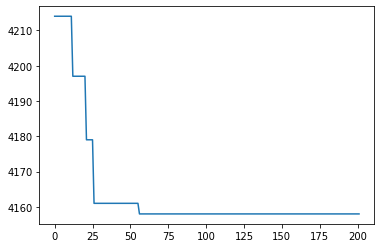

In [47]:
sc = []
it = list(range(len(score_plot)))
print(len(it))
for score in score_plot:
    sc.append(score[1])

plt.plot(it, sc)

In [59]:
def full_sch_vis(new_s, ndh_t, filename):
    swapped_schedule = {}
    # print(deadhead_trips)
    dh_tripz = deepcopy(ndh_t)
    
    trip_num = 0
    for bus in new_s.keys():
        new_sch = []
        for trip in new_s[bus]:
            new_sch.append(['t', trip[1], trip[2]])
            trip_num += 1

        for dh in dh_tripz:
                if dh[0] == bus:
                    new_sch.append(['d', dh[3], dh[4]])

        swapped_schedule[bus] = sorted(new_sch, key=lambda y: y[1])   

    swapped_schedule_copy = deepcopy(swapped_schedule)

    for bus in swapped_schedule.keys():
        charging_trips = []
        for t in range(1,len(swapped_schedule[bus])):
            if swapped_schedule[bus][t][1] != swapped_schedule[bus][t-1][2]:
                if swapped_schedule[bus][t-1][0] == 'd' and swapped_schedule[bus][t-1][0] == swapped_schedule[bus][t][0]:
                    label = 'c'
                else:
                    label = 's'
                charging_trips.append([label, swapped_schedule[bus][t-1][2], swapped_schedule[bus][t][1]])

        swapped_schedule[bus].extend(charging_trips)
        swapped_schedule[bus].sort(key=lambda y: y[1])

    for bus in swapped_schedule.keys():
        for t in range(2,len(swapped_schedule[bus])):
            if swapped_schedule[bus][t][0] == 'c' and swapped_schedule[bus][t-2][0] == swapped_schedule[bus][t][0]:
#                 print(swapped_schedule[bus][t])
                swapped_schedule[bus][t][0] = 's'
    #     break


    ctr = 1
    pos = {}
    edges = []
    edge_color = []

    new_trip_graph = nx.Graph()
    for bus in swapped_schedule.items():
        for seq in bus[1]:
            pos[ctr] = (seq[1], bus[0])
            ctr += 1
            pos[ctr] = (seq[2], bus[0])
            ctr += 1
            edges.append((ctr-2,ctr-1))
            if seq[0] == 't':
                edge_color.append('red')
            elif seq[0] == 'd':
                edge_color.append('blue')
            elif seq[0] == 'c':
                edge_color.append('green')
            else:
                edge_color.append('yellow')
    
    fig = plt.figure(figsize=(15,5))
    new_trip_graph.add_nodes_from(pos)
    new_trip_graph.add_edges_from(edges)
    nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
    plt.savefig(filename)
    
#     return swapped_schedule_copy

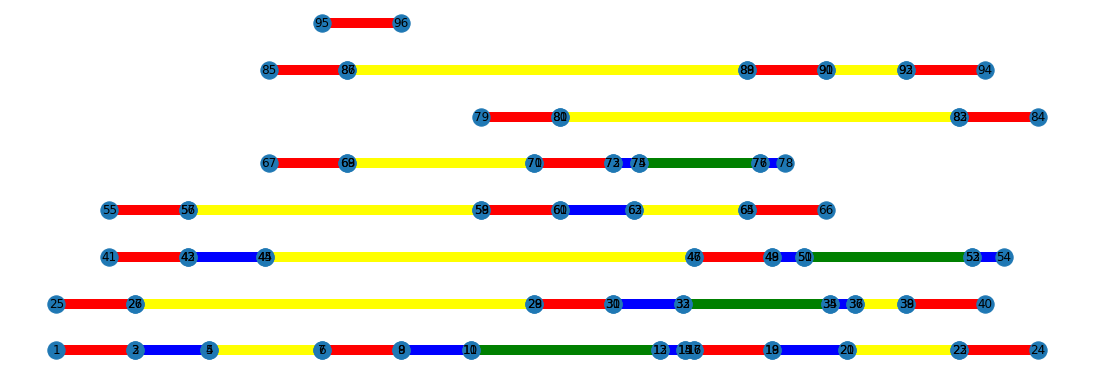

In [50]:
full_sch_vis(best, ndh)

small\10_cen_2_max_freq_2\in\lc.txt
small\10_cen_2_max_freq_2\base_graph.gpickle
small\10_cen_2_max_freq_2\in\updated_path_graph.gpickle
small\10_cen_2_max_freq_2\in\deadhead_path_graph.gpickle
small\10_cen_2_max_freq_2\in\depot_node.pickle
small\10_cen_2_max_freq_2\vertexpos.pickle

[8329, (135.91313541846853, 61.91196118229122)]
('l1', [8013, 8549, 7.25, 0.37, 1, (162.17376637946606, 8.121095179544595), 13.06])
('l2', [8549, 8013, 7.5, 0.37, 1, (56.532379990296455, 171.1736203427307), 13.06])
('l3', [8465, 8022, 7.25, 0.37, 1, (6.069911756740496, 27.18585195185702), 12.78])
('l4', [8022, 8465, 7.5, 0.37, 1, (148.69949070841432, 161.46580241783744), 12.78])
('l5', [8711, 8172, 7.0, 0.3, 2, (23.377983000558302, 144.88494821325926), 10.56])
('l6', [8172, 8711, 6.75, 0.3, 2, (167.86409653766017, 49.208471624214496), 10.56])
('l7', [8735, 8022, 7.0, 0.3, 2, (26.997602141263616, 55.771348330844006), 10.63])
('l8', [8022, 8735, 6.75, 0.3, 2, (148.69949070841432, 161.46580241783744), 10.63])

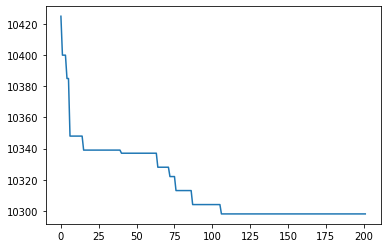

small\10_cen_2_max_freq_2\in\lc.txt
small\10_cen_2_max_freq_2\base_graph.gpickle
small\10_cen_2_max_freq_2\out\updated_path_graph.gpickle
small\10_cen_2_max_freq_2\out\deadhead_path_graph.gpickle
small\10_cen_2_max_freq_2\out\depot_node.pickle
small\10_cen_2_max_freq_2\vertexpos.pickle

[8183, (49.23690865079315, 138.38496741048692)]
('l1', [8013, 8549, 7.25, 0.37, 1, (162.17376637946606, 8.121095179544595), 13.06])
('l2', [8549, 8013, 7.5, 0.37, 1, (56.532379990296455, 171.1736203427307), 13.06])
('l3', [8465, 8022, 7.25, 0.37, 1, (6.069911756740496, 27.18585195185702), 12.78])
('l4', [8022, 8465, 7.5, 0.37, 1, (148.69949070841432, 161.46580241783744), 12.78])
('l5', [8711, 8172, 7.0, 0.3, 2, (23.377983000558302, 144.88494821325926), 10.56])
('l6', [8172, 8711, 6.75, 0.3, 2, (167.86409653766017, 49.208471624214496), 10.56])
('l7', [8735, 8022, 7.0, 0.3, 2, (26.997602141263616, 55.771348330844006), 10.63])
('l8', [8022, 8735, 6.75, 0.3, 2, (148.69949070841432, 161.46580241783744), 10.6

<Figure size 432x288 with 0 Axes>

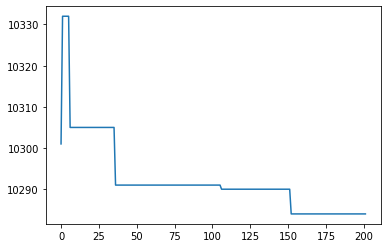

<Figure size 432x288 with 0 Axes>

In [295]:
import glob
import itertools

v=['in','out']
cs=['small','medium']
for i in v:
    for s in cs:
        for j in glob.glob(s+"/*/"+i+'/'):
#     break
            filename_lc = j.replace('out','in')+"lc.txt"
            filename_base_graph = j.replace(i,'').replace("\\\\","\\")+"base_graph.gpickle"
            filename_updated_path_graph = j+"updated_path_graph.gpickle"
            filename_deadhead_path_graph = j+"deadhead_path_graph.gpickle"
            filename_depot = j+"depot_node.pickle"
            filename_vertexpos = j.replace(i,'').replace("\\\\","\\")+"vertexpos.pickle"
            
            scale = 20
            
            print(filename_lc)
            print(filename_base_graph)
            print(filename_updated_path_graph)
            print(filename_deadhead_path_graph)
            print(filename_depot)
            print(filename_vertexpos)
            
            lcon, vertexpos, depot_node, T, P, P_dh = read_lc(filename_lc, filename_base_graph, filename_updated_path_graph, filename_deadhead_path_graph, filename_depot,filename_vertexpos)
              
            print(T)
            print(depot_node)
            for line in lcon.items():
                print(line)
            
            start_dh, end_dh = create_stop_dists(lcon, T, P_dh, depot_node)

            stop_dist = station_dist(lcon, P, P_dh, scale, start_dh, depot_node)
    
#             print('*'*100)
      
#             with open(filename_depot, 'rb') as handle:
#                 depot_node = pickle.load(handle)
            
#             print(depot_node)#.replace(i,'').replace("\\\\","\\"))
            Optimize_SA(lcon, depot_node, stop_dist, j)
            
            break
        break
#     print('a')
#     break

small/10_cen_2_max_freq_2/in/lc.txt
small/10_cen_2_max_freq_2/base_graph.gpickle
small/10_cen_2_max_freq_2/in/updated_path_graph.gpickle
small/10_cen_2_max_freq_2/in/deadhead_path_graph.gpickle
small/10_cen_2_max_freq_2/in/depot_node.pickle
small/10_cen_2_max_freq_2/vertexpos.pickle

[8329, (135.91313541846853, 61.91196118229122)]
('l1', [8013, 8549, 7.25, 0.37, 1, (162.17376637946606, 8.121095179544595), 13.06])
('l2', [8549, 8013, 7.5, 0.37, 1, (56.532379990296455, 171.1736203427307), 13.06])
('l3', [8465, 8022, 7.25, 0.37, 1, (6.069911756740496, 27.18585195185702), 12.78])
('l4', [8022, 8465, 7.5, 0.37, 1, (148.69949070841432, 161.46580241783744), 12.78])
('l5', [8711, 8172, 7.0, 0.3, 2, (23.377983000558302, 144.88494821325926), 10.56])
('l6', [8172, 8711, 6.75, 0.3, 2, (167.86409653766017, 49.208471624214496), 10.56])
('l7', [8735, 8022, 7.0, 0.3, 2, (26.997602141263616, 55.771348330844006), 10.63])
('l8', [8022, 8735, 6.75, 0.3, 2, (148.69949070841432, 161.46580241783744), 10.63])

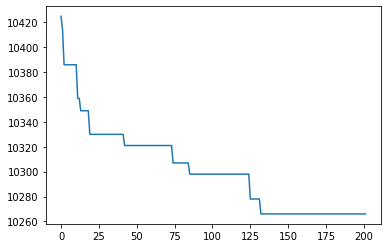

small/10_cen_2_max_freq_2/in/lc.txt
small/10_cen_2_max_freq_2/base_graph.gpickle
small/10_cen_2_max_freq_2/out/updated_path_graph.gpickle
small/10_cen_2_max_freq_2/out/deadhead_path_graph.gpickle
small/10_cen_2_max_freq_2/out/depot_node.pickle
small/10_cen_2_max_freq_2/vertexpos.pickle

[8183, (49.23690865079315, 138.38496741048692)]
('l1', [8013, 8549, 7.25, 0.37, 1, (162.17376637946606, 8.121095179544595), 13.06])
('l2', [8549, 8013, 7.5, 0.37, 1, (56.532379990296455, 171.1736203427307), 13.06])
('l3', [8465, 8022, 7.25, 0.37, 1, (6.069911756740496, 27.18585195185702), 12.78])
('l4', [8022, 8465, 7.5, 0.37, 1, (148.69949070841432, 161.46580241783744), 12.78])
('l5', [8711, 8172, 7.0, 0.3, 2, (23.377983000558302, 144.88494821325926), 10.56])
('l6', [8172, 8711, 6.75, 0.3, 2, (167.86409653766017, 49.208471624214496), 10.56])
('l7', [8735, 8022, 7.0, 0.3, 2, (26.997602141263616, 55.771348330844006), 10.63])
('l8', [8022, 8735, 6.75, 0.3, 2, (148.69949070841432, 161.46580241783744), 10.6

<Figure size 432x288 with 0 Axes>

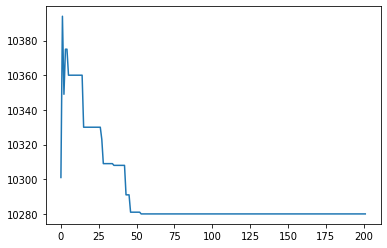

<Figure size 432x288 with 0 Axes>

In [296]:
import glob
import itertools

v=['in','out']
cs=['small','medium']

for s in cs:
    for j in glob.glob(s+"/*/"):
        for i in v:
#     break
            filename_lc = j.replace("\\","/")+i.replace("out", "in")+"/"+"lc.txt"
            filename_base_graph = j.replace("\\","/")+"base_graph.gpickle"
            filename_updated_path_graph = j.replace("\\","/")+i+"/"+"updated_path_graph.gpickle"
            filename_deadhead_path_graph = j.replace("\\","/")+i+"/"+"deadhead_path_graph.gpickle"
            filename_depot = j.replace("\\","/")+i+"/"+"depot_node.pickle"
            filename_vertexpos = j.replace("\\","/")+"vertexpos.pickle"

#             scale = 20
#             print(filename_lc)
#             print(filename_base_graph)
#             print(filename_updated_path_graph)
#             print(filename_deadhead_path_graph)
#             print(filename_depot)
#             print(filename_vertexpos)
            
            lcon, vertexpos, depot_node, T, P, P_dh = read_lc(filename_lc, filename_base_graph, filename_updated_path_graph, filename_deadhead_path_graph, filename_depot,filename_vertexpos)

#             print(T)
#             print(depot_node)
#             for line in lcon.items():
#                 print(line)
                
            start_dh, end_dh = create_stop_dists(lcon, T, P_dh, depot_node)

            stop_dist = station_dist(lcon, P, P_dh, scale, start_dh, depot_node)
      
#             with open(filename_depot, 'rb') as handle:
#                 depot_node = pickle.load(handle)
            
#             print(depot_node)#.replace(i,'').replace("\\\\","\\"))
            
            it, sc = Optimize_SA(lcon, depot_node, stop_dist, j.replace("\\","/")+i+"/")
            
#             break
        break
#     print('a')
    break

In [242]:
# filename_lc = "small/1_cen_2_max_freq_2/in/lc.txt"
# filename_base_graph = "small/1_cen_2_max_freq_2/base_graph.gpickle"
# filename_updated_path_graph = "small/1_cen_2_max_freq_2/in/updated_path_graph.gpickle"
# filename_deadhead_path_graph = "small/1_cen_2_max_freq_2/in/deadhead_path_graph.gpickle"
# filename_depot = "small/1_cen_2_max_freq_2/in/depot_node.pickle"
# filename_vertexpos = "small/1_cen_2_max_freq_2/vertexpos.pickle"

# lcon_copy, vertexpos_copy, depot_node_copy, T_copy, P_copy, P_dh_copy = read_lc(filename_lc, filename_base_graph, filename_updated_path_graph, filename_deadhead_path_graph, filename_depot,filename_vertexpos)

# for line in lcon_copy.items():
#     print(line)
# print('-'*100)

# print(depot_node_copy)
# print('-'*50)

# start_dh, end_dh = create_stop_dists(lcon_copy, T_copy, P_dh_copy, depot_node_copy, j)

In [243]:
# from difflib import SequenceMatcher

# a = [8329, 8283, 8029, 8089, 8019, 8460, 8020, 8090, 8165, 8227, 8291, 8352, 8407, 8457, 8503, 8543, 8581, 8615, 8646, 8676, 8022]
# b = [8465, 8508, 8462, 8413, 8359, 8299, 8518, 8176, 8321, 8031, 8282, 8328, 8380, 8453, 8529, 8495, 8067, 8392, 8346, 8144, 8209, 8268, 8319, 8127, 8057, 8255, 8718, 8635, 8723, 8742, 8764, 8683, 8708, 8731, 8090, 8165, 8227, 8291, 8352, 8407, 8457, 8503, 8543, 8581, 8615, 8646, 8676, 8022]
# b = b[::-1]
# if a[0] != b[0] and a[-1] != b[-1]:
#     b = b[::-1]
# print(a)
# print(b)

# s = SequenceMatcher(None, a, b)
# alo, blo, size = s.find_longest_match(0, len(a), 0, len(b))
# c = a[alo:alo+size]
# print(c)

# print(b[:blo] + a[:alo+1][::-1])

In [131]:
# import glob

# # v=['in','out']
# cs=['small','medium']
# # for i in v:
# for s in cs:
#     for j in glob.glob(s+"/*/"):
        
#         filename_updated_path_graph = j+"in/updated_path_graph.gpickle"
#         P = nx.read_gpickle(filename_updated_path_graph)
        
#         filename_updated_path_graph_copy = j+"out/updated_path_graph.gpickle"
#         P_copy = nx.read_gpickle(filename_updated_path_graph_copy)
# #         scale = 20
        
# #         print(j)
#         print(nx.is_isomorphic(P, P_copy))

# #         lcon, vertexpos, depot_node, T, P, P_dh = read_lc(filename_lc, filename_base_graph, filename_updated_path_graph, filename_deadhead_path_graph, filename_depot,filename_vertexpos)
# #         break
# #     break
#     break